In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.utils import image_dataset_from_directory
from keras import layers
from PIL import Image
from tensorflow import clip_by_value
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import random as tf_random
import keras_cv

In [50]:
train_ds = image_dataset_from_directory(
    '../data/cinic-10_image_classification_challenge-dataset/train/',
    validation_split=0.2,
    subset='training',
    seed = 420,
    image_size=(32,32),
    batch_size=32)

class_names = train_ds.class_names

val_ds = image_dataset_from_directory(
    '../data/cinic-10_image_classification_challenge-dataset/train/',
    validation_split=0.2,
    subset='validation',
    seed = 420,
    image_size=(32,32),
    batch_size=32)

Found 90000 files belonging to 10 classes.
Using 72000 files for training.
Found 90000 files belonging to 10 classes.
Using 18000 files for validation.


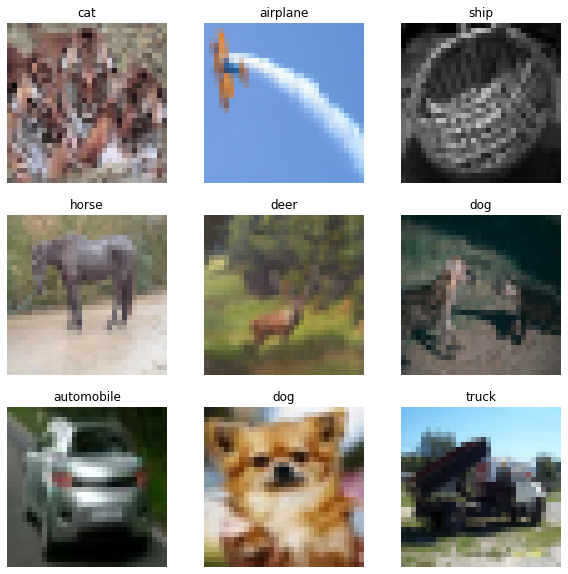

In [3]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

# below code is for data augmentations, applied during training, on batches, as layers of the model.

there's several layers:
- RescaleLayer
- RotateLayer
- FlipLayer
- DecolorizeLayer
- GaussianNoiseLayer

we use those at the beginning of our model

In [4]:
# rescale to 0-1 range
RescaleLayer = layers.Rescaling(1./255)

### rotations

In [5]:
RotateLayer = layers.RandomRotation(0.2)

### Flipping

In [6]:
FlipLayer = layers.RandomFlip("horizontal")

### Decolorization

In [7]:
class DecolorizationLayer(layers.Layer):
    def __init__(self):
        super(DecolorizationLayer, self).__init__()

    def call(self, inputs):
        # Convert RGB images to grayscale using luminosity method
        # The luminosity method takes into account human perception of color
        gray_images = tf.image.rgb_to_grayscale(inputs)
        return gray_images

### noise

In [8]:
class GaussianNoiseLayer(layers.Layer):
    def __init__(self, mean=0.0, stddev=1.0):
        super(GaussianNoiseLayer, self).__init__()
        self.mean = mean
        self.stddev = stddev

    def call(self, inputs, training=None):
        if training:
            noise = tf.random.normal(tf.shape(inputs), mean=self.mean, stddev=self.stddev, dtype=tf.float32)
            noisy_inputs = tf.clip_by_value(inputs + noise, 0.0, 255.0)  # Clip values to [0, 255]
            return noisy_inputs
        else:
            return inputs

Text(0.5, 1.0, 'Noisy')

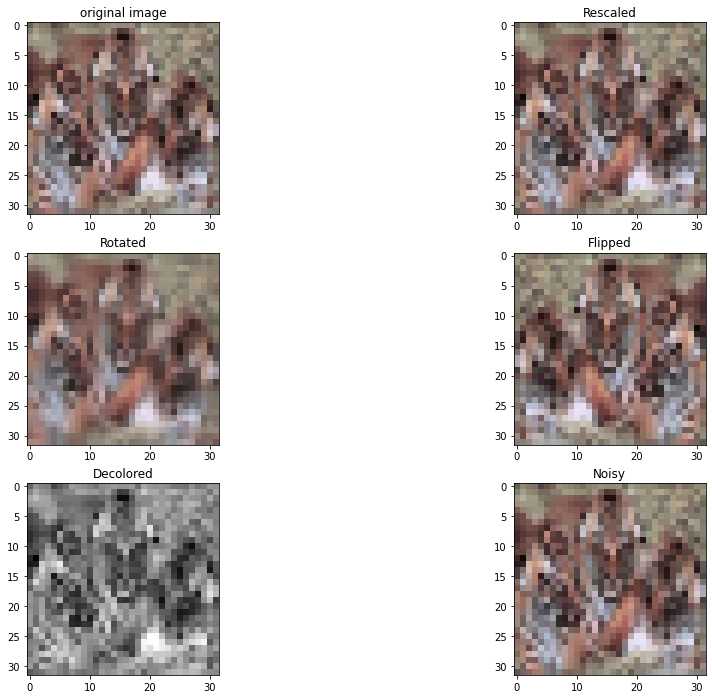

In [9]:
def get_var_name(var):
    for name, value in locals().items():
        if value is var:
            return name
        
image = images[0]
DecolorLayer = DecolorizationLayer()
NoiseLayer = GaussianNoiseLayer(stddev = 10)
fig, axes = plt.subplots(3, 2, figsize = (16,12))
axes = axes.flatten()
axes[0].imshow(tf.cast(image, tf.uint8))
axes[0].set_title('original image')
for augmentationLayer, ax in zip([RescaleLayer, RotateLayer, FlipLayer, DecolorLayer, NoiseLayer], axes[1:]):
    ax.imshow(tf.cast(augmentationLayer(image), tf.uint8 if not augmentationLayer == RescaleLayer else tf.float32), cmap = 'grey' if augmentationLayer == DecolorLayer else None)
axes[1].set_title('Rescaled')
axes[2].set_title('Rotated')
axes[3].set_title('Flipped')
axes[4].set_title('Decolored')
axes[5].set_title('Noisy')

In [25]:
IMAGE_SIZE = 32
num_classes = 10
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
def to_dict(image, label):
    # image = tf.image.resize(image, IMAGE_SIZE)
    # image = tf.cast(image, tf.float32)
    label = tf.one_hot(label, num_classes)
    return {"images": image, "labels": label}


def prepare_dataset(dataset, split):
    if split == "train":
        return (
            dataset.shuffle(10 * BATCH_SIZE)
            .map(to_dict, num_parallel_calls=AUTOTUNE)
            .batch(BATCH_SIZE)
        )
    if split == "test":
        return dataset.map(to_dict, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)

In [67]:
cut_mix = keras_cv.layers.CutMix()
mix_up = keras_cv.layers.MixUp()

def cutmix(samples):
    samples = cut_mix(samples, training=True)
    return samples

def mixup(samples):
    samples = mix_up(samples, training=True)
    return samples

dict_train_ds = train_ds.map(to_dict, num_parallel_calls=AUTOTUNE)
dict_train_ds = dict_train_ds.map(cutmix, num_parallel_calls=AUTOTUNE)
def dict_to_tuple(element):
    return element['images'], element['labels']

cutmixed_ds = dict_train_ds.map(dict_to_tuple)
mixup_ds = dict_train_ds = dict_train_ds.map(mixup, num_parallel_calls=AUTOTUNE).map(dict_to_tuple)

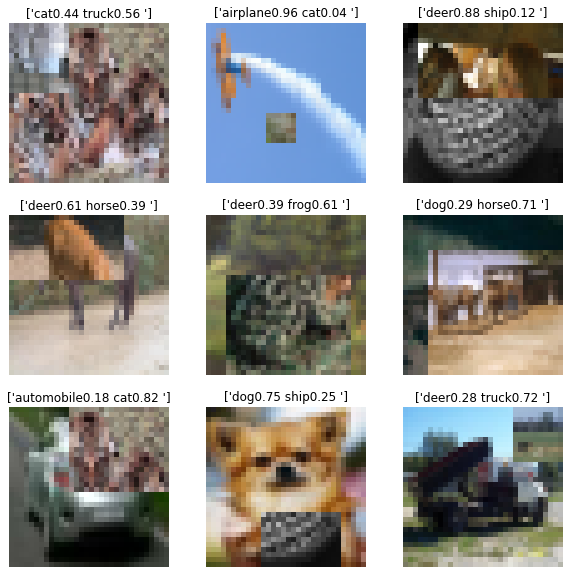

In [68]:
plt.figure(figsize=(10, 10))
for images, labels in cutmixed_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    label = ""
    for j, val in enumerate(labels[i]):
            if val > 0:
                label += class_names[j] + str(np.round(val, 2)) + " "
    plt.title([label])
    plt.axis("off")

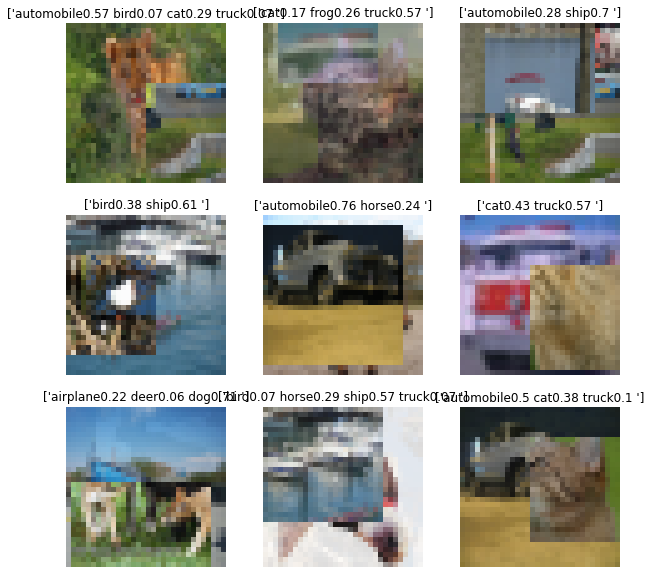

In [70]:
plt.figure(figsize=(10, 10))
for images, labels in mixup_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    label = ""
    for j, val in enumerate(labels[i]):
            if val > 0.02:
                label += class_names[j] + str(np.round(val, 2)) + " "
    plt.title([label])
    plt.axis("off")